In [1]:
# import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

cuda1 = torch.device('cuda:1')

In [2]:
import numpy as np

In [3]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask):
        super(RealNVP, self).__init__()
        
        self.mask = nn.Parameter(mask, requires_grad=False).cuda(1)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def f(self, z):
        x = z
        log_det_J = z.new_zeros(z.shape[0])
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
            log_det_J += s.sum(dim=1)
        return x, log_det_J

    def f_inv(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

In [4]:
n,p = int(100),1000

X = torch.randn(n,p).cuda(1)

d = 5

(np.random.normal(5,1,[d])).tolist()

w0 = torch.from_numpy(np.array([(np.random.normal(5,1,[d])).tolist() +[0]*(p-d)]).astype(np.float32)).t().cuda(1)


psi = (X@w0)[:,0]


y = psi + torch.rand(n).cuda(1) * 0.1

In [5]:
total_param = p*2 + 4 # needs to be even

mask1 = [0,1]* int(total_param/2)
mask2 = [1- x for x in mask1]

nets = lambda: nn.Sequential(nn.Linear(total_param, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, total_param), nn.Tanh()).cuda(1)
nett = lambda: nn.Sequential(nn.Linear(total_param, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, total_param)).cuda(1)
masks = torch.from_numpy(np.array([mask1, mask2] * 4).astype(np.float32)).cuda(1)


K = 3

flow_list = [RealNVP(nets, nett, masks) for _ in range(K)]

net_pi = lambda: nn.Sequential(nn.Linear(total_param, 256), nn.LeakyReLU(), nn.Linear(256, 256), 
                               nn.LeakyReLU(), nn.Linear(256, K), nn.Softmax(dim=1)).cuda(1)

flow_pi = net_pi()

In [6]:
batch_size = 256

In [7]:
beta = torch.rand([batch_size, total_param]).cuda(1)

In [8]:
beta.shape

torch.Size([256, 2004])

In [9]:
def loglik(theta):
    idx = 0
    idx1 = idx + p
    lam2 = torch.log(1+ torch.exp(theta[:,idx: idx1]))
    idx = idx1 

    idx = idx1
    idx1 = idx + p
    w = theta[:,idx: idx1]

    idx = idx1
    idx1 = idx + 1
    tau2 = torch.log(1+ torch.exp(theta[:,idx: idx1]))
    
    idx = idx1
    idx1 = idx + 1
    c2 = torch.log(1+ torch.exp(theta[:,idx: idx1]))
    
    idx = idx1
    idx1 = idx + 1
    sigma2 = torch.log(1+ torch.exp(theta[:,idx: idx1]))
    
    #prior loss
    sigma2_log_prior =  - 100*sigma2 # - (10+1) * torch.log(sigma2) - 0.01/sigma2
    tau2_log_prior = - 100*tau2 #- torch.log(1+ tau2/sigma2) - 0.5 * torch.log(sigma2)

    c2_log_prior =  - (5.0/2+1) * torch.log(c2) - 250.0/c2    
    lam2_log_prior = - torch.log(1+lam2)

    tau2_tilde = c2*lam2/(c2+ tau2*lam2)
    w_log_prior = - w **2/tau2_tilde/lam2/2.0  - torch.log(tau2_tilde * lam2 )/2.0
    
    psi = w@X.t()

    y_torch = torch.reshape(y,[1,n])

    lik = -(y - psi)**2/sigma2/2.0 - torch.log(sigma2)/2.0

    total_posterior= (lik).sum(dim=1) + (w_log_prior+ lam2_log_prior).sum(dim=1) + \
        tau2_log_prior.flatten() +  c2_log_prior.flatten() + sigma2_log_prior.flatten()
    
    return total_posterior

In [10]:
def log_reference(z):
    return  0 #- torch.sum((z/ref_sigma).pow(2)/2.0,dim=1)

In [11]:
para_list = list()

In [12]:
for flow in flow_list:
    para_list+= list(flow.parameters())
    
para_list +=  list(flow_pi.parameters())

In [13]:
optimizer = torch.optim.Adam([p for p in para_list if p.requires_grad==True], lr=1e-3)

In [14]:
from torch.distributions import gumbel

In [15]:
gum_rng= gumbel.Gumbel(0,1)


def soft_multinomial(Pi):
    lam = 0.1
    return torch.softmax((Pi.log() + gum_rng.sample(Pi.shape).cuda(1))/lam,1)


def soft_multinomial_log(logPi):
    lam = 0.1
    return torch.softmax((logPi + gum_rng.sample(logPi.shape).cuda(1))/lam,1)

In [16]:
import copy


best_loss = np.inf

In [17]:
def get_z(model, x):
    
    flow_list = model[0]
    flow_pi = model[1]
    
    Loglik_list = list()
    z_list = list()
    
    for k in range(K):

        flow = flow_list[k]
        z_cad, logdetJ = flow.f(x)
        Loglik_list.append(compLoglik.f(z_cad)+logdetJ + torch.log(flow_pi(z_cad)[:,k]))
        z_list.append(z_cad) 
        
    total_loglik = torch.logsumexp(torch.stack(Loglik_list), dim=0)
        
    loss =  -  total_loglik.mean()
        
    c = soft_multinomial_log(torch.stack(Loglik_list).t())
    z_candidates = torch.stack(z_list)
    z = torch.stack( [c[i]@ z_candidates[:,i,:] for i in range(x.shape[0])])
    
    return z

In [18]:
best_model= copy.deepcopy([flow_list , flow_pi])

In [19]:
optimizer = torch.optim.Adam([p for p in para_list if p.requires_grad==True], lr=1e-4)

In [20]:
for t in range(2000):
    
    beta =  torch.rand([batch_size, total_param]).cuda(1)
    
    Loglik_list = list()
    z_list = list()
    
    for k in range(K):

        flow = flow_list[k]
        z_cad, logdetJ = flow.f(beta)
        Loglik_list.append(loglik(z_cad)+logdetJ + torch.log(flow_pi(z_cad)[:,k]))
#         z_list.append(z_cad) 
        
    g = - torch.logsumexp(torch.stack(Loglik_list), dim=0) + log_reference(beta)
        
    loss =    g.mean() 

    
    if t%50==0:
        print(t, loss.item())
    
    if loss.item()< best_loss:
        best_model= copy.deepcopy([flow_list , flow_pi])
        best_loss = loss.item()
        
    if np.isnan(loss.cpu().data.numpy()):    
        flow_list,flow_pi = best_model
          

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

0 23848.53125
50 1681.2388916015625
100 205.69139099121094
150 -392.5390319824219
200 -718.39013671875
250 -841.4964599609375
300 -882.71142578125
350 -899.3077392578125
400 -921.0725708007812
450 -941.1267700195312
500 -952.3216552734375
550 -967.1424560546875
600 -976.957275390625
650 -984.8984375
700 -995.3848266601562
750 -1004.724609375
800 -1008.2353515625
850 -1020.405517578125
900 -1024.990478515625
950 -1028.164794921875
1000 -1035.32470703125
1050 -1040.7813720703125
1100 -1050.219970703125
1150 -1060.16650390625
1200 -1063.5833740234375
1250 -1070.7958984375
1300 -1068.060546875
1350 -1079.152099609375
1400 -1082.402099609375
1450 -1094.185791015625
1500 -1096.846435546875
1550 -1100.236572265625
1600 -1104.7191162109375
1650 -1102.1099853515625
1700 -1116.092041015625
1750 -1115.434814453125
1800 -1119.045166015625
1850 -1128.436279296875
1900 -1121.0450439453125
1950 -1131.7666015625


In [21]:
beta =  torch.rand([1000, total_param]).cuda(1) 

Loglik_list = list()
z_list = list()

for k in range(K):

    flow = flow_list[k]
    z_cad, logdetJ = flow.f(beta)
    Loglik_list.append(loglik(z_cad)+logdetJ + torch.log(flow_pi(z_cad)[:,k]))
    z_list.append(z_cad) 

g = - torch.logsumexp(torch.stack(Loglik_list), dim=0) + log_reference(beta)

loss =    g.mean() 


c = soft_multinomial_log(torch.stack(Loglik_list).t())
z_candidates = torch.stack(z_list)

z = torch.stack( [c[i]@ z_candidates[:,i,:] for i in range(beta.shape[0])])


theta = z

idx = 0
idx1 = idx + p
lam2_post = torch.log(1+ torch.exp(theta[:,idx: idx1]))

idx = idx1
idx1 = idx + p
w_post = theta[:,idx: idx1]

idx = idx1
idx1 = idx + 1
tau2_post = torch.log(1+ torch.exp(theta[:,idx: idx1]))

idx = idx1
idx1 = idx + 1
c2_post = torch.log(1+ torch.exp(theta[:,idx: idx1]))

idx = idx1
idx1 = idx + 1
sigma2_post = torch.log(1+ torch.exp(theta[:,idx: idx1]))


w_post = w_post.cpu().detach().numpy()

In [22]:
(w_post[np.logical_not(np.isnan(w_post[:,0]))]).mean(axis=0)[:d+5]

array([ 4.6140113e+00,  7.2987046e+00,  5.6765904e+00,  6.4654732e+00,
        3.2114265e+00, -6.9254986e-04, -1.1840308e-04,  4.2035765e-05,
       -1.0390395e-03, -2.3168295e-03], dtype=float32)

In [23]:
import seaborn as sns
import pandas as pd

In [24]:
w5 = pd.DataFrame( {'Value': w_post[:,:10].flatten(order='F'), 
                    'w': np.repeat(np.arange(1,11),w_post.shape[0]),
                    'Method': "Transport"
                   })

In [25]:
w5_2 = pd.DataFrame( {'Value': np.repeat(w0.cpu().numpy()[:10],w_post.shape[0]) + 
                      np.random.randn(10*w_post.shape[0])*0.0001, 
                    'w': np.repeat(np.arange(1,11),w_post.shape[0]),
                    'Method': "Oracle"
                   })

In [26]:
w_long = pd.concat([w5, w5_2])

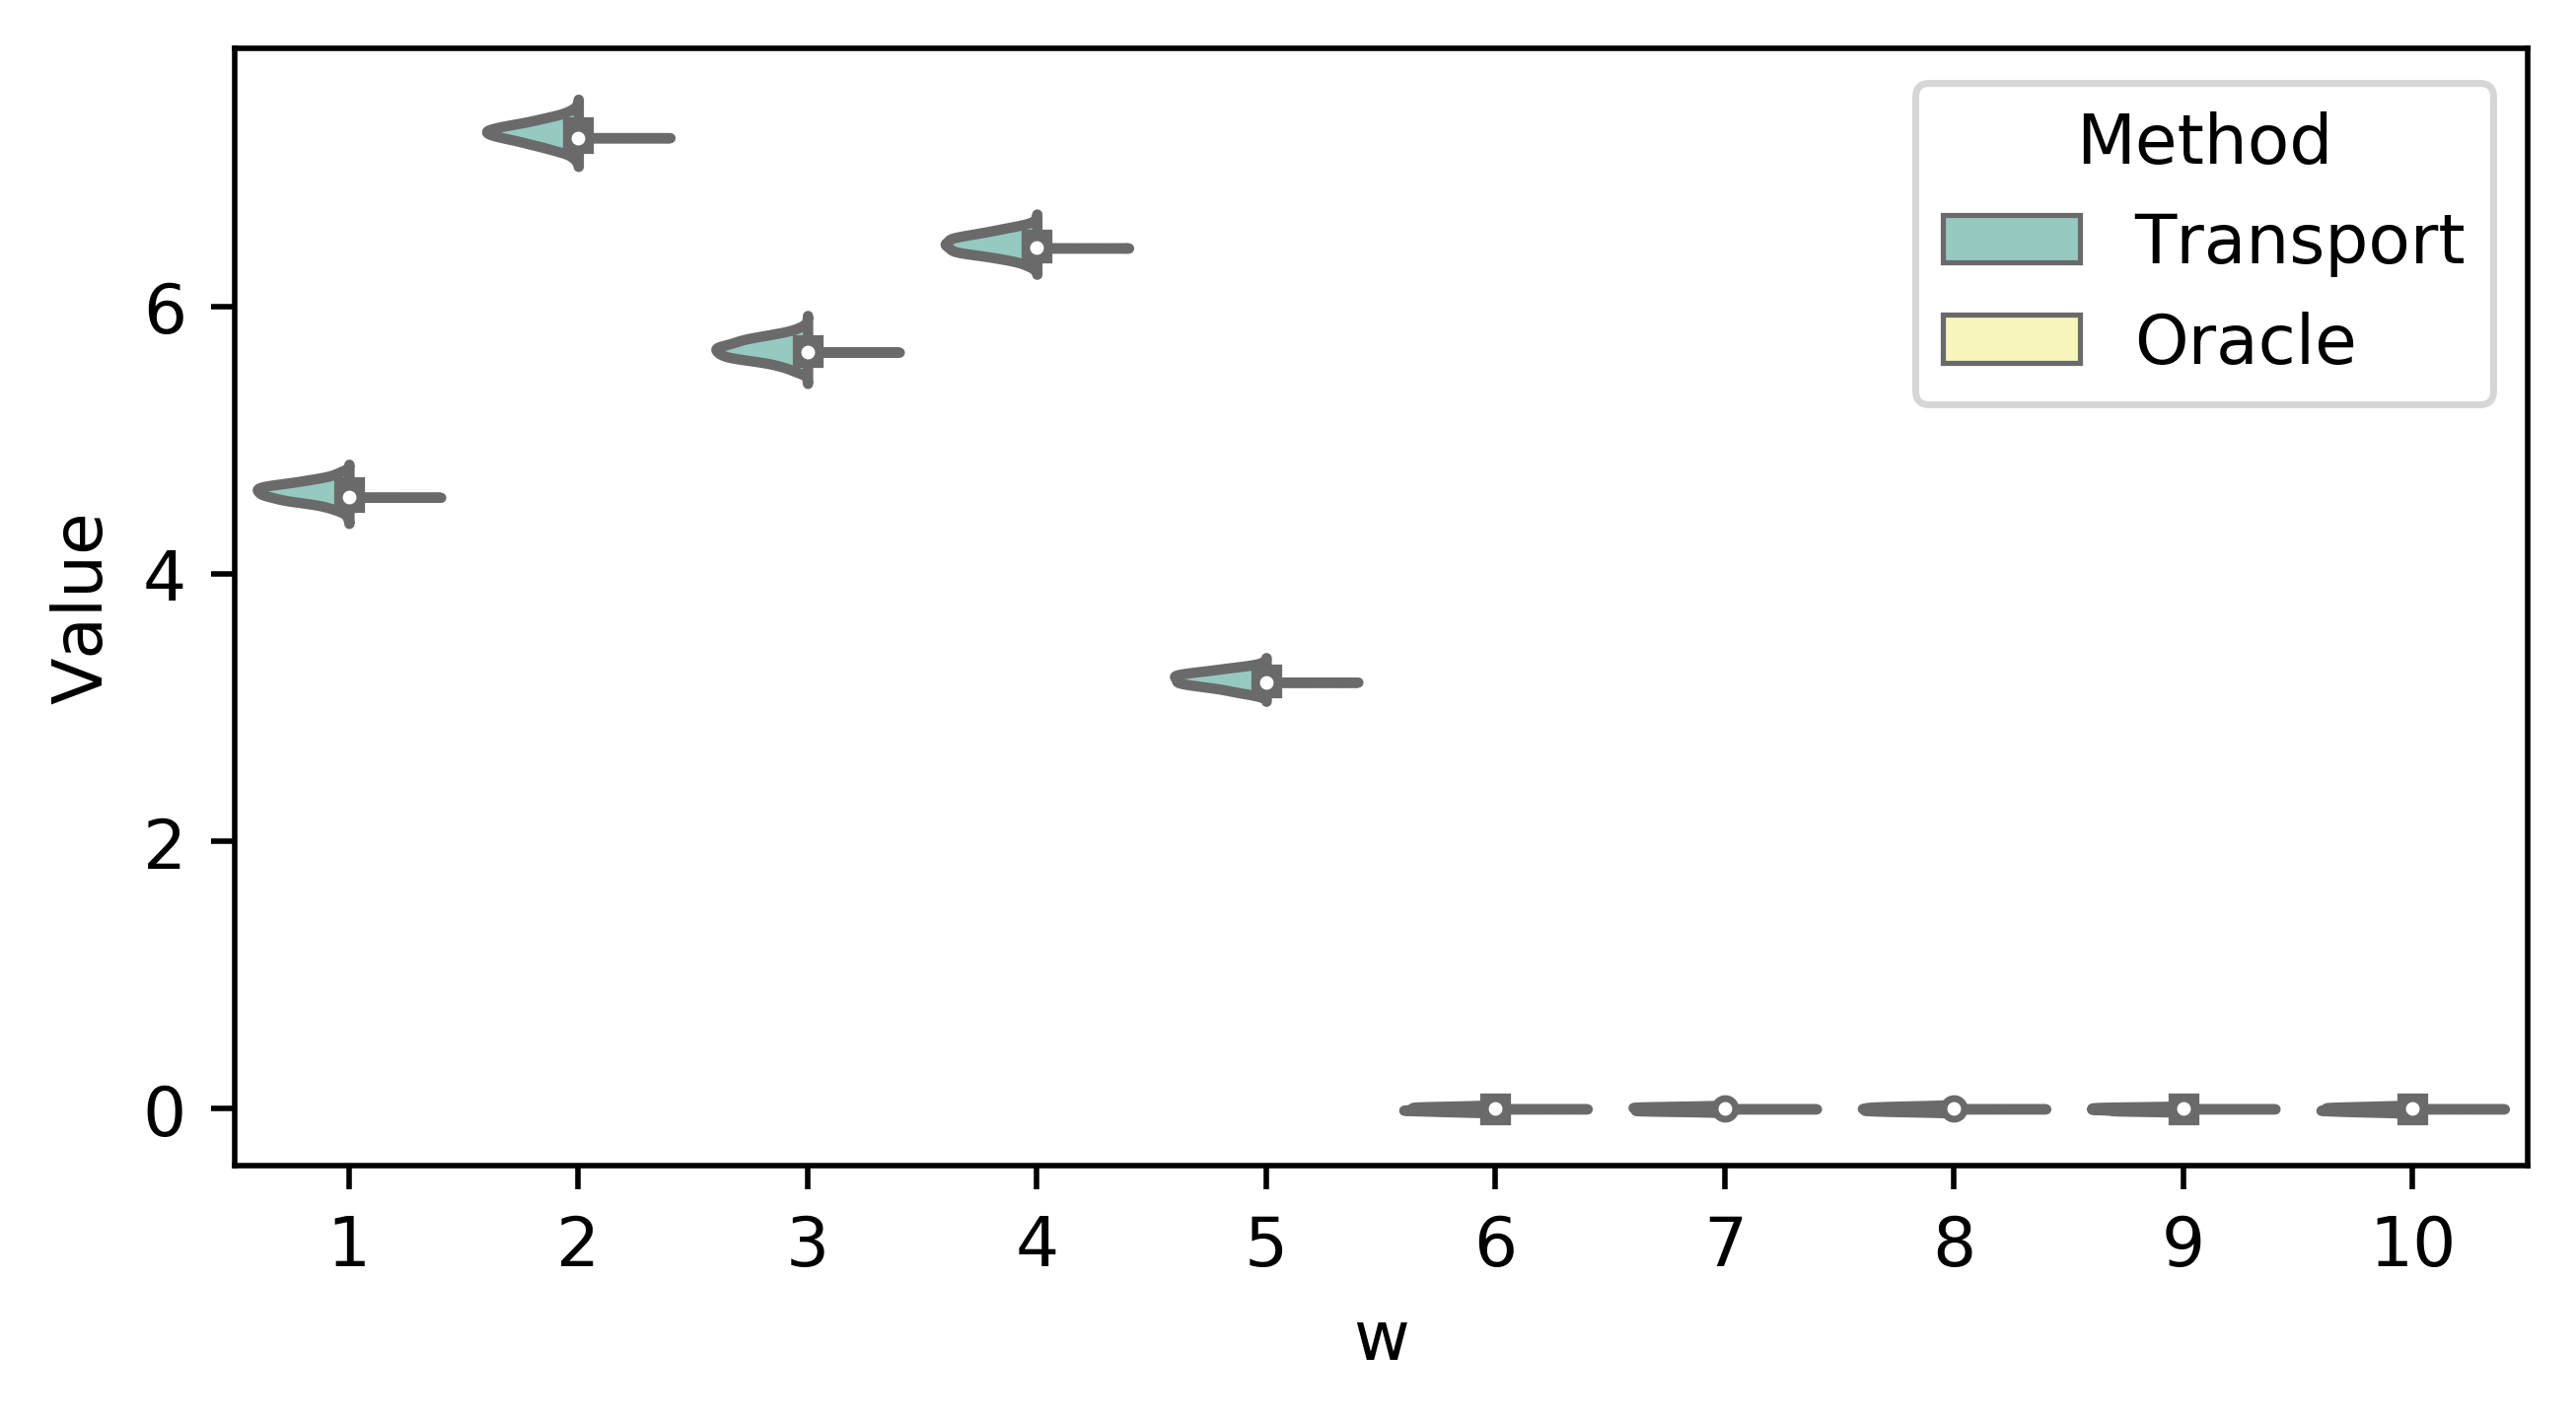

In [27]:
fig = plt.figure(figsize=(6, 3),dpi=500 )       # size in inches

ax = sns.violinplot(x="w", y="Value",data=w_long, hue="Method",
                    palette="Set3",
                    split=True,    scale="count")


# plt.savefig("horseshoe.png")